# Pertemuan 10
- Image Transformation
    - Fourier Transform (DFT & IDFT)
    - Performance Optimization of DFT
    - CUDA Implementation
- Image Histogram
    - Find & Plot Histogram
    - Histogram Equalization (Global Contrast & CLAHE)
    - CUDA Implementation
___
### Maximizing Jetson Nano Perfomance

In [ ]:
# sudo nvpmodel -m 0
# sudo jetson_clocks

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# check OpenCV Version

cv2.__version__

___
# 1. Image Transform
## 1.1 Fourier Transform (DFT & IDFT)
- Fourier Transform is used to analyze the frequency characteristics of various filters.<br>
<img src="resource/fourier.jpeg" style="width:450px"></img><br>
*1D Fourier Transform*<br><br>
- For images, **2D Discrete Fourier Transform (DFT)** is used to find the **frequency domain**. 
- The output of the transformation represents the image in the Fourier or **frequency domain**, 
- while the input image is the **spatial domain** equivalent. 
- A fast algorithm called **Fast Fourier Transform (FFT)** is used for calculation of **DFT**. 
- Then we can revert frequency domain data back into image using **Inverse DFT**.<br>
<img src="resource/Fourier2.png" style="width:450px"></img><br>
*2D Fourier Transform in Image*<br><br>

___
## Fourier Transform (Numpy)
- Numpy has an FFT package to find Fourier Transform on Image. 
- Funtion `np.fft.fft2(a, s)` provides us the **frequency transform** which will be a **complex array**. 
- Where : 
    - `a` : is the input image (array), which is grayscale image(`cv2.CV_8UC1`).
    - `s` : is optional which decides the size of output array. (`s[0]` refers to `axis 0`, `s[1]` to `axis 1`).
- Then, we need to move zero frequency component to the center using `np.fft.fftshift(a)`, (It is more easier to analyze).
- Where : 
    - `a` : in input array generated by `np.fft.fft2(a, s)`
- After that, we can find the **magnitude spectrum** using formula : <br><br>
$magnitude = 20*log(|f_{shift}|)$

In [ ]:
# load image
img = cv2.imread('lena.jpg')

# conver to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# apply FFT to gray image (result frequency transform matrix)
f = np.fft.fft2(gray)

# move zero frequency component to the center using `np.fft.fftshift()`
fshift = np.fft.fftshift(f)

# find magnitude spectrum = 20*log(|fshift|)
magnitude_spectrum = 20*np.log(np.abs(fshift))

# show result
plt.figure(figsize=(15,7))

plt.subplot(1, 2, 1)
plt.imshow(gray, cmap = 'gray')
plt.title('Input Image') 

plt.subplot(1, 2, 2)
plt.imshow(magnitude_spectrum, cmap = 'gray')
plt.title('Magnitude Spectrum')

- See, You can see **more white region** at the center showing **low frequency** content is more.
- So you found the **frequency transform** Now you can do some operations in **frequency domain**, like **high pass filtering** and **reconstruct the image**, ie find **inverse DFT**. 
<br><br><br>
____
## Apply HPF and Do Image Reconstruction From Frequency Domain To Generate Edge Image
- Remove the low frequencies by masking with a rectangular window of size 60x60.
- Then apply the inverse shift using `np.fft.ifftshift()`, (DC component come at the top-left corner).
- Then find inverse FFT using `np.ifft2()` function. 
- The result, will be a complex number, use `np.real()` to convert that into real number.

In [ ]:
h, w = gray.shape
ch, cw = h//2 , w//2

# create 0 masking window with size 60x60 at the center of fshift to remove the low frequencies
# We call it as HPF (High Pass Filter) that will be produce Edge image later.
fshift[ch-30 : ch+31, cw-30 : cw+31] = 0

# apply inverse FFT Shift (move DC component to top-left corner)
f_ishift = np.fft.ifftshift(fshift)

# apply inverse FFT 
img_back = np.fft.ifft2(f_ishift)

# convert to real number using `np.real()`
img_back = np.real(img_back)


# show result
plt.figure(figsize=(20,10))

plt.subplot(1, 3, 1)
plt.imshow(gray, cmap = 'gray')
plt.title('Input Image')

plt.subplot(1, 3, 2)
plt.imshow(img_back, cmap = 'gray')
plt.title('Image after HPF')

plt.subplot(1, 3, 3)
plt.imshow(img_back)
plt.title('Result in JET')

- Colormap Jet vs gray, <br>
![](resource/colormap.png)

____
## Fourier Transform in OpenCV
- OpenCV provides the functions `cv2.dft(src, dst, flags, nonzeroRows)` and `cv2.idft(src, dst, flags, nonzeroRows)` for this. 
- Where : 
    - `src` : input array that could be real or complex.
    - `dst` : output array whose size and type depends on the flags .
    - `flags` : transformation flags,
        - `cv2.DFT_INVERSE` : performs an inverse 1D or 2D transform instead of the default forward transform.
        - `cv2.DFT_SCALE` : scales the result: divide it by the number of array elements. Normally, it is combined with `cv2.DFT_INVERSE`.
        - `cv2.DFT_ROWS` : performs a forward or inverse transform of every individual row of the input matrix.
        - `cv2.DFT_COMPLEX_OUTPUT` : performs a forward transformation of 1D or 2D real array; the result, though being a complex array.
        - `cv2.DFT_REAL_OUTPUT` : performs an inverse transformation of a 1D or 2D complex array; the result, though being a real array.
    - `nonzeroRows` :	number of dst rows to process; the rest of the rows have undefined content (see the convolution sample in dft description.
- Then calculate magnitude from 2D vector using `cv2.magnitude(x, y)`,
- Where : 
    - `x` : array in x coordinate.
    - `y` : array in y coordinate.


Text(0.5,1,'Magnitude Spectrum')

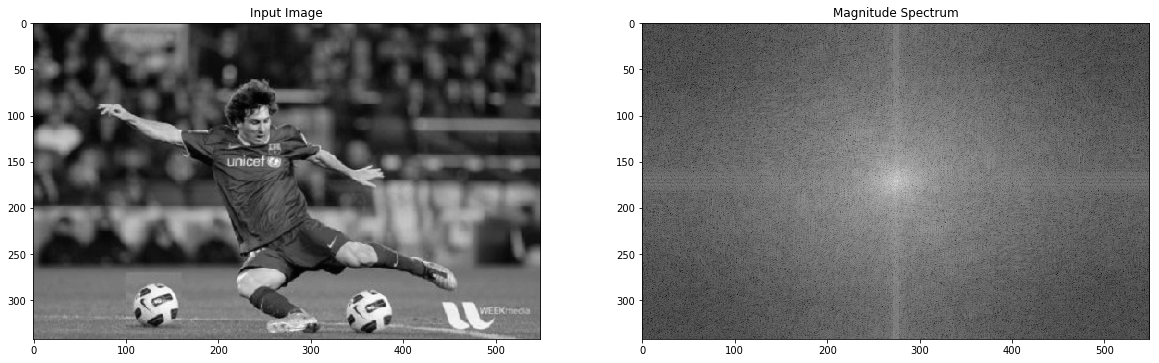

In [190]:
# load image
img = cv2.imread('messi.jpg')

# convert to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# convert grayscale image from uint8 (CV_8UC1) to float32 (CV_32FC1)
gray = gray.astype(np.float32)

# apply DFT to find frequency transform matrix
dft = cv2.dft(gray, flags = cv2.DFT_COMPLEX_OUTPUT)

# move zero frequency component to the center using `np.fft.fftshift()`
dft_shift = np.fft.fftshift(dft)

# find magnitude spectrum = 20*log(|magnitude|)
x = dft_shift[:,:,0]
y = dft_shift[:,:,1]
magnitude = cv2.magnitude(x, y)
magnitude_spectrum = 20*np.log(magnitude)


# show result
plt.figure(figsize=(20,10))

plt.subplot(1, 2, 1)
plt.imshow(gray, cmap = 'gray')
plt.title('Input Image')

plt.subplot(1, 2, 2)
plt.imshow(magnitude_spectrum, cmap = 'gray')
plt.title('Magnitude Spectrum')

### Note : 
- You can also use `cv2.cartToPolar(x, y)` which returns both **magnitude** and **angel** in a single shot.<br><br><br>

____
## Apply LPF and Do Image Reconstruction in Frequency Domain To Generate Blur Image
- Apply Inverse DFT using `cv2.idft(src, dst, flags, nonzeroRows)`
- Then remove high frequency contents in the image, by applying LPF (Low Pass Filter) to image taht will be **blurs the image**. 
- For this, we create a mask first with **high value (1)** at **low frequencies**, (we pass the `LF` content, and `0` at `HF` region).

In [ ]:
h, w = gray.shape
ch, cw = h//2 , w//2

# create a mask first, center square is 1 with size 60x60 (pass the LF content), remaining all 0.
mask = np.zeros((h, w, 2), np.uint8)
mask[ch-30 : ch+30, cw-30 : cw+30] = 1

# apply mask to frequency domain matrix
fshift = dft_shift*mask

# apply inverse FFT Shift (move DC component to top-left corner)
f_ishift = np.fft.ifftshift(fshift)

# apply inverse DFT
img_back = cv2.idft(f_ishift)

# find a magnitude from 2D IDFT vector
x = img_back[:,:,0]
y = img_back[:,:,1]
img_back = cv2.magnitude(x, y)


# show result
plt.figure(figsize=(20,10))

plt.subplot(1, 2, 1)
plt.imshow(gray, cmap = 'gray')
plt.title('Input Image')

plt.subplot(1, 2, 2)
plt.imshow(img_back, cmap = 'gray')
plt.title('Magnitude Spectrum')

_____
## 1.2 Performance Optimization of DFT
- Performance of DFT calculation is fastest when array size is **power of two**. 
- The arrays whose size is a product of 2’s, 3’s, and 5’s are also processed quite efficiently. 
- OpenCV provides a function, `cv2.getOptimalDFTSize(n)` for this. 
- Where : 
    - `n` : is number of columns or rows in our input matrix.


In [ ]:
# load image
img = cv2.imread('messi.jpg')

# convert to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

h, w = gray.shape
print("Original Size %d, %d" % (h, w))

# Find optimal rows and column for DFT & IDFT
nh = cv2.getOptimalDFTSize(h)
nw = cv2.getOptimalDFTSize(w)
print("Optimize Size %d, %d" % (nh, nw))

In [ ]:
# to use the optimized rows and columns above, we need to add padding into the image, 
# simply just using zero matrix 

# create zero matrix with size of optimized matrix size above
nimg = np.zeros((nh, nw))

# insert the grayscale image into zero matrix image
nimg[:h, :w] = gray

In [ ]:
# measure perfomance DFT calculation for original image with size (342, 549) - messi.jpg

gray = gray.astype(np.float32)

%timeit dft1 = cv2.dft(gray, flags=cv2.DFT_COMPLEX_OUTPUT)

In [ ]:
# measure perfomance DFT calculation for zero padded image with optimized size (360, 576) - messi.jpg
nimg = nimg.astype(np.float32)

%timeit dft2 = cv2.dft(nimg, flags = cv2.DFT_COMPLEX_OUTPUT)

### Note :
- `%timeit` is python magic syntax for measure execution time of small code snippets

____
## 1.3 CUDA Implementation
- Create Object using class `cv2.cuda.createDFT(dft_size, flags=0)`
- Where : 
    - `dft_size` : is the image size.
    - `flags` : 
        - `cv2.DFT_INVERSE` : performs an inverse 1D or 2D transform instead of the default forward transform.
        - `cv2.DFT_SCALE` : scales the result: divide it by the number of array elements. Normally, it is combined with `cv2.DFT_INVERSE`.
        - `cv2.DFT_ROWS` : performs a forward or inverse transform of every individual row of the input matrix.
        - `cv2.DFT_COMPLEX_INPUT` : performs a forward transformation of 1D or 2D real array; the result, though being a complex array.
        - `cv2.DFT_REAL_OUTPUT` : performs an inverse transformation of a 1D or 2D complex array; the result, though being a real array.
- Then use method `.compute(src, dst)` to find frequency matrix of DFT
- Where : 
    - `src` : input image matrix (GPU Mat), Only `cv2.CV_32FC1` images are supported for now.
    - `dst` : output frequency matrix (GPU Mat)
- And to convert from Frequency matrix to magnitude, we can use `cv2.cuda.magnitude(x, y)`
- Where : 
    - `x` : array in x coordinate.
    - `y` : array in y coordinate.

Text(0.5,1,'Magnitude Spectrum')

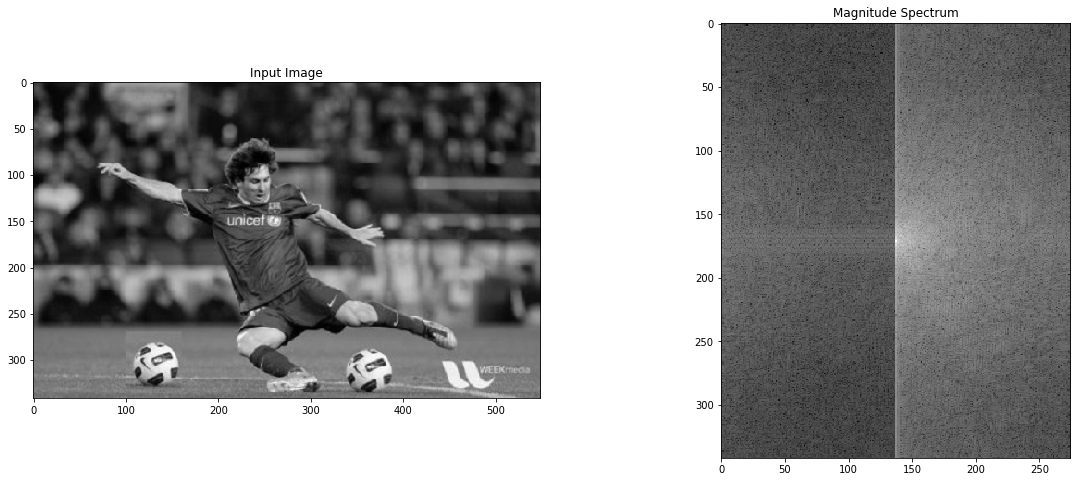

In [189]:
# load image in Host memory
img = cv2.imread("messi.jpg")
h, w, c = img.shape

# GPU memory initialization
img_GpuMat = cv2.cuda_GpuMat() # Create GpuMat object 
img_GpuMat.create((w, h), cv2.CV_32FC3) # cv2.CV_32FC3 -> 32 bit float image 3 channel
gray_GpuMat = cv2.cuda_GpuMat() # Create GpuMat object 
gray_GpuMat.create((w, h), cv2.CV_32FC1) # cv2.CV_32FC1 -> 32 bit float image 1 channel

# Create DFT Object
DFT = cv2.cuda.createDFT((w, h), flags=0)

# upload to GPU memory as 32 bit float matrix
img_GpuMat.upload(img.astype(np.float32))

# convert to grayscale using CUDA
cv2.cuda.cvtColor(img_GpuMat, cv2.COLOR_BGR2GRAY, gray_GpuMat)

# compute DFT to grayscale to find frequency transform matrix
dft_GpuMat = DFT.compute(gray_GpuMat)

# download to host memory
gray = gray_GpuMat.download() 
dft = dft_GpuMat.download()

# move zero frequency component to the center using `np.fft.fftshift()`
dft_shift = np.fft.fftshift(dft)

# find magnitude spectrum = 20*log(|magnitude|)
x = dft_shift[:,:,0]
y = dft_shift[:,:,1]
magnitude = cv2.magnitude(x, y)
magnitude_spectrum = 20*np.log(magnitude)

# show result
plt.figure(figsize=(20,8))

plt.subplot(1, 2, 1)
plt.imshow(gray, cmap = 'gray')
plt.title('Input Image')

plt.subplot(1, 2, 2)
plt.imshow(magnitude_spectrum, cmap = 'gray')
plt.title('Magnitude Spectrum')

____
____
# 2. Image Histogram
- Histogram Image is a graph or plot to find out intensity distribution of an image.
- It is a plot with pixel values (ranging from 0 to 255, not always) in **X-axis**,
- and corresponding number of pixels in the image on **Y-axis**.<br>
    ![](resource/histogram_sample.jpg)<br>
- By looking at the histogram of an image, you get intuition about **contrast**, **brightness**, **intensity** distribution etc of that image.
- **Left** region of histogram shows the amount of **darker pixels** in image.
- **Right** region shows the amount of **brighter pixels** in image. 
<br><br><br>
____
## 2.1 Find & Plot Histogram
### 2.1.1 Find Histogram using OpenCV
- OpenCV provide `cv2.calcHist([img], [channels], mask, [histSize], [ranges])`,
- Where : 
    - `img` : it is the source image of type uint8 or float32.
    - `channels` : It is the index of channel for which we calculate histogram. 0, 1, 2 for RGB image. 0 for Grayscale image.
    - `mask` : mask image. To find histogram of full image, it is given as `None`. But if you want to find histogram of particular region of image, you have to create a mask image for that and give it as mask.
    - `histSize` : this represents our BIN count, we pass [256].
    - `ranges` : this is our RANGE. Normally, it is [0,256].

In [ ]:
# load image
img = cv2.imread('lena.jpg')

# convert ot grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find histogram using OpenCV for grayscale image, channel 0, mask=None, histSize=256, ranges = [0,256]
hist = cv2.calcHist([gray], [0], None, [256], [0,256])


### 2.1.2 Find Histogram Using Numpy
- Numpy also provides you a function, `np.histogram()`. 
- So instead of `cv2.calcHist()` function, you can try below line :

In [ ]:
# load image
img = cv2.imread('lena.jpg')

# convert ot grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find histogram using Numpy for grayscale image, bins=256, range = [0,256]
hist, bins = np.histogram(gray.ravel(),256,[0,256])

____
## 2.2 Plot Histogram
### 2.2.1 Plot Histogram Using Matplotlib [OPTION 1]
- Matplotlib comes with a histogram plotting function : `matplotlib.pyplot.hist()`
- It directly finds the histogram and plot it. 
- You need not use `cv2.calcHist()` or `np.histogram()` function to find the histogram.

In [ ]:
# load image
img = cv2.imread('lena.jpg')

# convert ot grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

plt.hist(gray.ravel(), 256, [0,256])
plt.show()

### 2.2.2 Plot Histogram Using Matplotlib + OpenCV [OPTION 2]

In [ ]:
# load image
img = cv2.imread('lena.jpg')

# convert ot grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find histogram for grayscale image
histr = cv2.calcHist([gray],[0],None,[256],[0,256])

# plot result
plt.plot(histr)
plt.xlim([0,256])

In [ ]:
# Or, Plot all channel histogram

# load image
img = cv2.imread('lena.jpg')

# loop to all channel
color = ('b','g','r') # color for each channel
for i,col in enumerate(color):
    # find histogram in channel i-th
    histr = cv2.calcHist([img],[i],None,[256],[0,256])

    # plot histogram for each channel
    plt.plot(histr,color = col)
    plt.xlim([0,256])
plt.show()

____
## 2.3 Histogram Equalization
- Consider an image whose pixel values are confined to some specific range of values only. 
- For eg, brighter image will have all pixels confined to high values. 
- But a good image will have pixels from all regions of the image. 
So you need to stretch this histogram to either ends (as given in below image, from wikipedia) and that is what **Histogram Equalization** does (in simple words). 
- This normally improves the contrast of the image. <br><br>
    ![](resource/histogram_equalization.png)


In [ ]:
# load image
img = cv2.imread('Unequalized_Hawkes_Bay_NZ.jpg')

# convert ot grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find histogram from grayscale image
hist = cv2.calcHist([gray],[0],None,[256],[0,256])

# calculate cummulative histogram data
cdf = hist.cumsum() # cumulative distribution functions (CDF) of histogram value
cdf_normalized = cdf * float(hist.max()) / cdf.max() # normalize CDF data


# show result
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
plt.imshow(gray, cmap="gray")

plt.subplot(1,2,2)
# plot histogram (red) & cumulative distribution functions data (blue)
plt.plot(cdf_normalized, color = 'b')
plt.plot(hist, color = 'r')
plt.xlim([0,256])
plt.legend(('cdf','histogram'), loc = 'upper left')
plt.show()

- You can see histogram lies in brighter region. 
- We need the full spectrum (strech histogram into minimum and maximum value). 
- For that, we need a transformation function which maps the input pixels in brighter region to output pixels in full region. 
- That is what histogram equalization does.<br><br><br>

___
## Histogram Equalization using Numpy
- Now, we need to strech histogram into minimum and maximum value.
- Find the minimum histogram value (excluding 0) and apply the histogram equalization equation. 
- To do this mask all 0 value in CDF data using numpy `np.ma.masked_equal()`, who will be mask array with a given value.

In [ ]:
# Example how numpy mask array work

a = np.arange(4)
print(a)
print(list(np.ma.masked_equal(a, 2)))

- Strech Histogram using simple normalization formula<br><br>
$X = (x - min)/(max - min)$

In [ ]:
# apply mask to zero value
cdf_m = np.ma.masked_equal(cdf,0)

# streach CDF to full range histogram (min - max)
cdf_m = (cdf_m - cdf_m.min())*255/(cdf_m.max()-cdf_m.min())

# apply unmask and set to zero
cdf = np.ma.filled(cdf_m,0).astype(np.uint8)

In [ ]:
cdf

In [ ]:
# convert each pixel value in grayscale image into cdf value at the same index pixel
gray2 = cdf[gray]

# find histogram from grayscale 2 image
hist = cv2.calcHist([gray2],[0],None,[256],[0,256])

# calculate cummulative histogram data
cdf = hist.cumsum() # cumulative distribution functions (CDF) of histogram value
cdf_normalized = cdf * float(hist.max()) / cdf.max() # normalize CDF data

# show result
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
plt.imshow(gray2, cmap="gray")

plt.subplot(1,2,2)
plt.plot(cdf_normalized, color = 'b')
plt.plot(hist, color = 'r')
plt.xlim([0,256])
plt.legend(('cdf','histogram'), loc = 'upper left')
plt.show()

___
## Histograms Equalization in OpenCV
- OpenCV has a function to do this, `cv2.equalizeHist(src)`. 
- Its input is just grayscale image and output is our histogram equalized image.

In [ ]:
# load image
img = cv2.imread('Unequalized_Hawkes_Bay_NZ.jpg')

# convert to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# apply OpenCV Histogram Equalization to grayscale image
equ = cv2.equalizeHist(gray)

# find histogram from equalized image
hist = cv2.calcHist([equ],[0],None,[256],[0,256])


# calculate cummulative histogram data
cdf = hist.cumsum() # cumulative distribution functions (CDF) of histogram value
cdf_normalized = cdf * float(hist.max()) / cdf.max() # normalize CDF data


# show result
plt.figure(figsize=(20,5))

plt.subplot(1,3,1)
plt.imshow(gray, cmap="gray")
plt.title("Original")

plt.subplot(1,3,2)
plt.imshow(equ, cmap="gray")
plt.title("Equalized")

plt.subplot(1,3,3)
plt.plot(cdf_normalized, color = 'b')
plt.plot(hist, color = 'r')
plt.xlim([0,256])
plt.legend(('cdf','histogram'), loc = 'upper left')
plt.title("Equalized Histogram Plot")
plt.show()

____
## 2.4 Histogram Equalization using CLAHE (Contrast Limited Adaptive Histogram Equalization)
- The first histogram equalization we just saw, considers the **global contrast** of the image. 
- In many cases, it is not a good idea. 
- For example, result after global histogram equalization for `tsukuba_l.png.png`, <br>
![](resource/global_contrast.png)<br><br>
- It is true that the **background contrast has improved** after histogram equalization. 
- But compare the face of statue in both images. 
- We lost most of the information there due to over-brightness. 
- It is because its histogram is not confined to a particular region as we saw in previous cases.<br><br><br>
- So to solve this problem, **adaptive histogram equalization** (CLAHE) is used. 
- In this, image is divided into **small blocks** called **"tiles"** (tileSize is 8x8 by default in OpenCV). 
- Then each of these blocks are histogram equalized as usual. 
- So in a small area, histogram would confine to a small region (unless there is noise).
<br><br>
- Create object using `cv2.createCLAHE(clipLimit , tileGridSize)`,
- Where : 
    - `clipLimit` : Threshold for contrast limiting.
    - `tileGridSize` : Size of grid for histogram equalization. Input image will be divided into equally sized rectangular tiles. tileGridSize defines the number of tiles in row and column.
- Then use method `.apply(img)`, to generate equalized image,

In [ ]:
# load image
img = cv2.imread('tsukuba_l.png')

# convert to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# create a CLAHE object (Arguments are optional).
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))

# apply CLAHE
cl = clahe.apply(gray)


# find histogram from clahe equalized image
hist = cv2.calcHist([cl],[0],None,[256],[0,256])

# calculate cummulative histogram data
cdf = hist.cumsum() # cumulative distribution functions (CDF) of histogram value
cdf_normalized = cdf * float(hist.max()) / cdf.max() # normalize CDF data


# show result
plt.figure(figsize=(20,5))

plt.subplot(1,3,1)
plt.imshow(gray, cmap="gray")
plt.title("Original")

plt.subplot(1,3,2)
plt.imshow(cl, cmap="gray")
plt.title("CLAHE Equalized")

plt.subplot(1,3,3)
plt.plot(cdf_normalized, color = 'b')
plt.plot(hist, color = 'r')
plt.xlim([0,256])
plt.legend(('cdf','histogram'), loc = 'upper left')
plt.title("CLAHE Equalized Histogram Plot")
plt.show()

____
## 2.5 CUDA Implementation
### CUDA Find Histogram 
- Using method `cv2.cuda.calcHist(src, hist)`
- Where : 
    - `src` : source image, `CV_8UC1`.
    - `hist` : Destination histogram with one row, `256` columns, and the `CV_32SC1` type.
### CUDA Equalize Histogram 
- Using Method `cv2.cuda.equalizeHist(src, dst)`,
- Where : 
    - `src` : Source image with `CV_8UC1` type.
    - `dst` : Destination image.
### CUDA CLAHE
- Using Method `cv2.cuda.createCLAHE(clipLimit, tileGridSize)`
- Where : 
    - `clipLimit` : Threshold for contrast limiting.
    - `tileGridSize` : Size of grid for histogram equalization. Input image will be divided into equally sized rectangular tiles. tileGridSize defines the number of tiles in row and column.
- Then use method `.apply(src, Stream, dst)` to find equalized image,
- Where : 
    - `Stream` : is CUDA Stream, if not set : `cv2.cuda_Stream.Null()`

In [ ]:
# load image in Host memory
img = cv2.imread("tsukuba_l.png")
h, w, c = img.shape

# GPU memory initialization
img_GpuMat = cv2.cuda_GpuMat() # Create GpuMat object 
img_GpuMat.create((w, h), cv2.CV_8UC3) # cv2.CV_8UC3 -> 8bit image 3 channel
gray_GpuMat = cv2.cuda_GpuMat() # Create GpuMat object 
gray_GpuMat.create((w, h), cv2.CV_8UC1) # cv2.CV_8UC1 -> 8bit image 1 channel
equ_GpuMat = cv2.cuda_GpuMat() # Create GpuMat object 
equ_GpuMat.create((w, h), cv2.CV_8UC1) # cv2.CV_8UC1 -> 8bit image 1 channel
clahe_GpuMat = cv2.cuda_GpuMat() # Create GpuMat object 
clahe_GpuMat.create((w, h), cv2.CV_8UC1) # cv2.CV_8UC1 -> 8bit image 1 channel
hist_equ_GpuMat = cv2.cuda_GpuMat() # Create GpuMat object 
hist_equ_GpuMat.create((1, 256), cv2.CV_32SC1) # cv2.CV_32SC1
hist_clahe_GpuMat = cv2.cuda_GpuMat() # Create GpuMat object 
hist_clahe_GpuMat.create((1, 256), cv2.CV_32SC1) # cv2.CV_32SC1


# Create CLAHE Object
CLAHE = cv2.cuda.createCLAHE(clipLimit=5.0, tileGridSize=(8,8))

# upload to GPU memory as 32 bit float matrix
img_GpuMat.upload(img)

# convert to grayscale using CUDA
cv2.cuda.cvtColor(img_GpuMat, cv2.COLOR_BGR2GRAY, gray_GpuMat)


# apply CUDA Equalize Histogram & CLAHE
cv2.cuda.equalizeHist(gray_GpuMat, equ_GpuMat)
CLAHE.apply(gray_GpuMat, cv2.cuda_Stream.Null(), clahe_GpuMat)

# CUDA find histogram
cv2.cuda.calcHist(equ_GpuMat, hist_equ_GpuMat)
cv2.cuda.calcHist(clahe_GpuMat, hist_clahe_GpuMat)

# download to host memory
hist_cl = hist_clahe_GpuMat.download()
hist_equ = hist_equ_GpuMat.download() 
cl = clahe_GpuMat.download()
equ = equ_GpuMat.download() 

# show result
plt.figure(figsize=(20,10))

plt.subplot(2,3,1)
plt.imshow(gray, cmap="gray")
plt.title("Original")

plt.subplot(2,3,2)
plt.imshow(cl, cmap="gray")
plt.title("CLAHE Equalized")

plt.subplot(2,3,3)
plt.plot(hist_cl, color = 'r')
plt.xlim([0,256])
plt.legend(('cdf','histogram'), loc = 'upper left')
plt.title("CLAHE Equalized Histogram Plot")

plt.subplot(2,3,4)
plt.imshow(gray, cmap="gray")
plt.title("Original")

plt.subplot(2,3,5)
plt.imshow(equ, cmap="gray")
plt.title("Equalized")

plt.subplot(2,3,6)
plt.plot(hist_equ, color = 'r')
plt.xlim([0,256])
plt.legend(('cdf','histogram'), loc = 'upper left')
plt.title("Equalized Histogram Plot")
plt.show()

# Source : 
- [https://docs.opencv.org/4.5.2/de/dbc/tutorial_py_fourier_transform.html](https://docs.opencv.org/4.5.2/de/dbc/tutorial_py_fourier_transform.html)
- [https://docs.opencv.org/4.5.2/d2/de8/group__core__array.html#gadd6cf9baf2b8b704a11b5f04aaf4f39d](https://docs.opencv.org/4.5.2/d2/de8/group__core__array.html#gadd6cf9baf2b8b704a11b5f04aaf4f39d)
- [https://docs.opencv.org/4.5.2/d2/de8/group__core__array.html#gaf4dde112b483b38175621befedda1f1c](https://docs.opencv.org/4.5.2/d2/de8/group__core__array.html#gaf4dde112b483b38175621befedda1f1c)
- [https://en.wikipedia.org/wiki/Histogram_equalization](https://en.wikipedia.org/wiki/Histogram_equalization)
- [https://docs.opencv.org/4.5.2/d5/daf/tutorial_py_histogram_equalization.html](https://docs.opencv.org/4.5.2/d5/daf/tutorial_py_histogram_equalization.html)
